In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 600

base_path = '/Users/weilynnw/Desktop/CEE690-ESAA-main/assignment_2_data'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Q1:

In [35]:
 # UTILITY FUNCTIONS
def circular_day_difference(day1, day2, year_length=365):
    """
    Calculate smallest circular difference between two days of water year.
    Implements Tip 2 from assignment.
    
    Example: Dec 31 (day 365) to Jan 1 (day 1) = 1 day, not 364 days
    """
    diff = day2 - day1
    
    # Find shortest path around the circle
    if abs(diff) > year_length / 2:
        if diff > 0:
            diff = diff - year_length
        else:
            diff = diff + year_length
    
    return diff

def get_day_of_water_year(date):
    """
    Convert date to day of water year (1-365)
    Water year starts Oct 1
    """
    if date.month >= 10:
        wy_start = pd.Timestamp(date.year, 10, 1)
    else:
        wy_start = pd.Timestamp(date.year - 1, 10, 1)
    
    return (date - wy_start).days + 1

def add_water_year(df):
    """Add water year column (Oct-Sep)"""
    df['water_year'] = df['date'].apply(
        lambda x: x.year if x.month < 10 else x.year + 1
    )
    return df

# Load and preprocess reservoir data

In [36]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    
    # Rename columns for consistency
    df = df.rename(columns={
        'datetime': 'date',
        'inflow_cfs': 'inflow',
        'outflow_cfs': 'outflow'
    })
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Remove Feb 29 from leap years (Tip 1)
    df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()
    
    df = add_water_year(df)
    
    df = df.sort_values('date').reset_index(drop=True)
    
    return df
 # INDICATOR CALCULATIONS

In [37]:
def calculate_indicator_a(df):
    """
    (a) Percent change of average annual alteration of 3-day peak flow
    Formula: 100 * (Xout - Xin) / Xin
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        # Get data for this water year
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average peak
        in_3day_peak = wy_data['inflow'].rolling(window=3, center=False).mean().max()
        out_3day_peak = wy_data['outflow'].rolling(window=3, center=False).mean().max()
        
        # Calculate percent change
        pct_change = 100 * (out_3day_peak - in_3day_peak) / in_3day_peak
        
        results.append({
            'water_year': wy,
            'in_3day_peak': in_3day_peak,
            'out_3day_peak': out_3day_peak,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_b(df):
    """
    (b) Percent change of average annual alteration of 31-day low flow
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average minimum
        in_31day_low = wy_data['inflow'].rolling(window=31, center=False).mean().min()
        out_31day_low = wy_data['outflow'].rolling(window=31, center=False).mean().min()
        
        # Calculate percent change
        pct_change = 100 * (out_31day_low - in_31day_low) / in_31day_low
        
        results.append({
            'water_year': wy,
            'in_31day_low': in_31day_low,
            'out_31day_low': out_31day_low,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_c(df):
    """
    (c) Timing (day of water year) of 3-day peak flow
    Returns: circular difference in days (outflow - inflow timing)
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average
        wy_data['in_rolling_3day'] = wy_data['inflow'].rolling(window=3, center=False).mean()
        wy_data['out_rolling_3day'] = wy_data['outflow'].rolling(window=3, center=False).mean()
        
        # Find timing of peak
        in_peak_idx = wy_data['in_rolling_3day'].idxmax()
        out_peak_idx = wy_data['out_rolling_3day'].idxmax()
        
        in_peak_date = wy_data.loc[in_peak_idx, 'date']
        out_peak_date = wy_data.loc[out_peak_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_peak_date)
        out_day = get_day_of_water_year(out_peak_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_d(df):
    """
    (d) Timing (day of water year) of 31-day low flow
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average
        wy_data['in_rolling_31day'] = wy_data['inflow'].rolling(window=31, center=False).mean()
        wy_data['out_rolling_31day'] = wy_data['outflow'].rolling(window=31, center=False).mean()
        
        # Find timing of minimum
        in_low_idx = wy_data['in_rolling_31day'].idxmin()
        out_low_idx = wy_data['out_rolling_31day'].idxmin()
        
        in_low_date = wy_data.loc[in_low_idx, 'date']
        out_low_date = wy_data.loc[out_low_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_low_date)
        out_day = get_day_of_water_year(out_low_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_e(df):
    """
    (e) Flashiness (Richards-Baker Index)
    RBI = Σ|Q_i - Q_{i-1}| / ΣQ_i
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 2:
            continue
        
        # Calculate RBI for inflow
        in_diff = wy_data['inflow'].diff().abs().sum()
        in_total = wy_data['inflow'].sum()
        in_rbi = in_diff / in_total if in_total > 0 else np.nan
        
        # Calculate RBI for outflow
        out_diff = wy_data['outflow'].diff().abs().sum()
        out_total = wy_data['outflow'].sum()
        out_rbi = out_diff / out_total if out_total > 0 else np.nan
        
        # Difference
        rbi_diff = out_rbi - in_rbi
        
        results.append({
            'water_year': wy,
            'in_rbi': in_rbi,
            'out_rbi': out_rbi,
            'rbi_diff': rbi_diff
        })
    
    return pd.DataFrame(results)

\n================================================================================
RESERVOIR HYDROLOGICAL INDICATORS ANALYSIS
Assignment 2 - CEE690-ESAA

Found 9 reservoir(s):
  - FOL-daily-flows.csv
  - NML-daily-flows.csv
  - DNP-daily-flows.csv
  - PNF-daily-flows.csv
  - CLE-daily-flows.csv
  - SHA-daily-flows.csv
  - EXC-daily-flows.csv
  - ORO-daily-flows.csv
  - BER-daily-flows.csv

Analyzing: FOL
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -28.72%
  (b) Avg % change 31-day low:      61.79%
  (c) Avg timing diff 3-day:         25.8 days
  (d) Avg timing diff 31-day:        48.2 days
  (e) Avg RBI difference:         -0.1104

Analyzing: NML
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -10.44%
  (b) Avg % change 

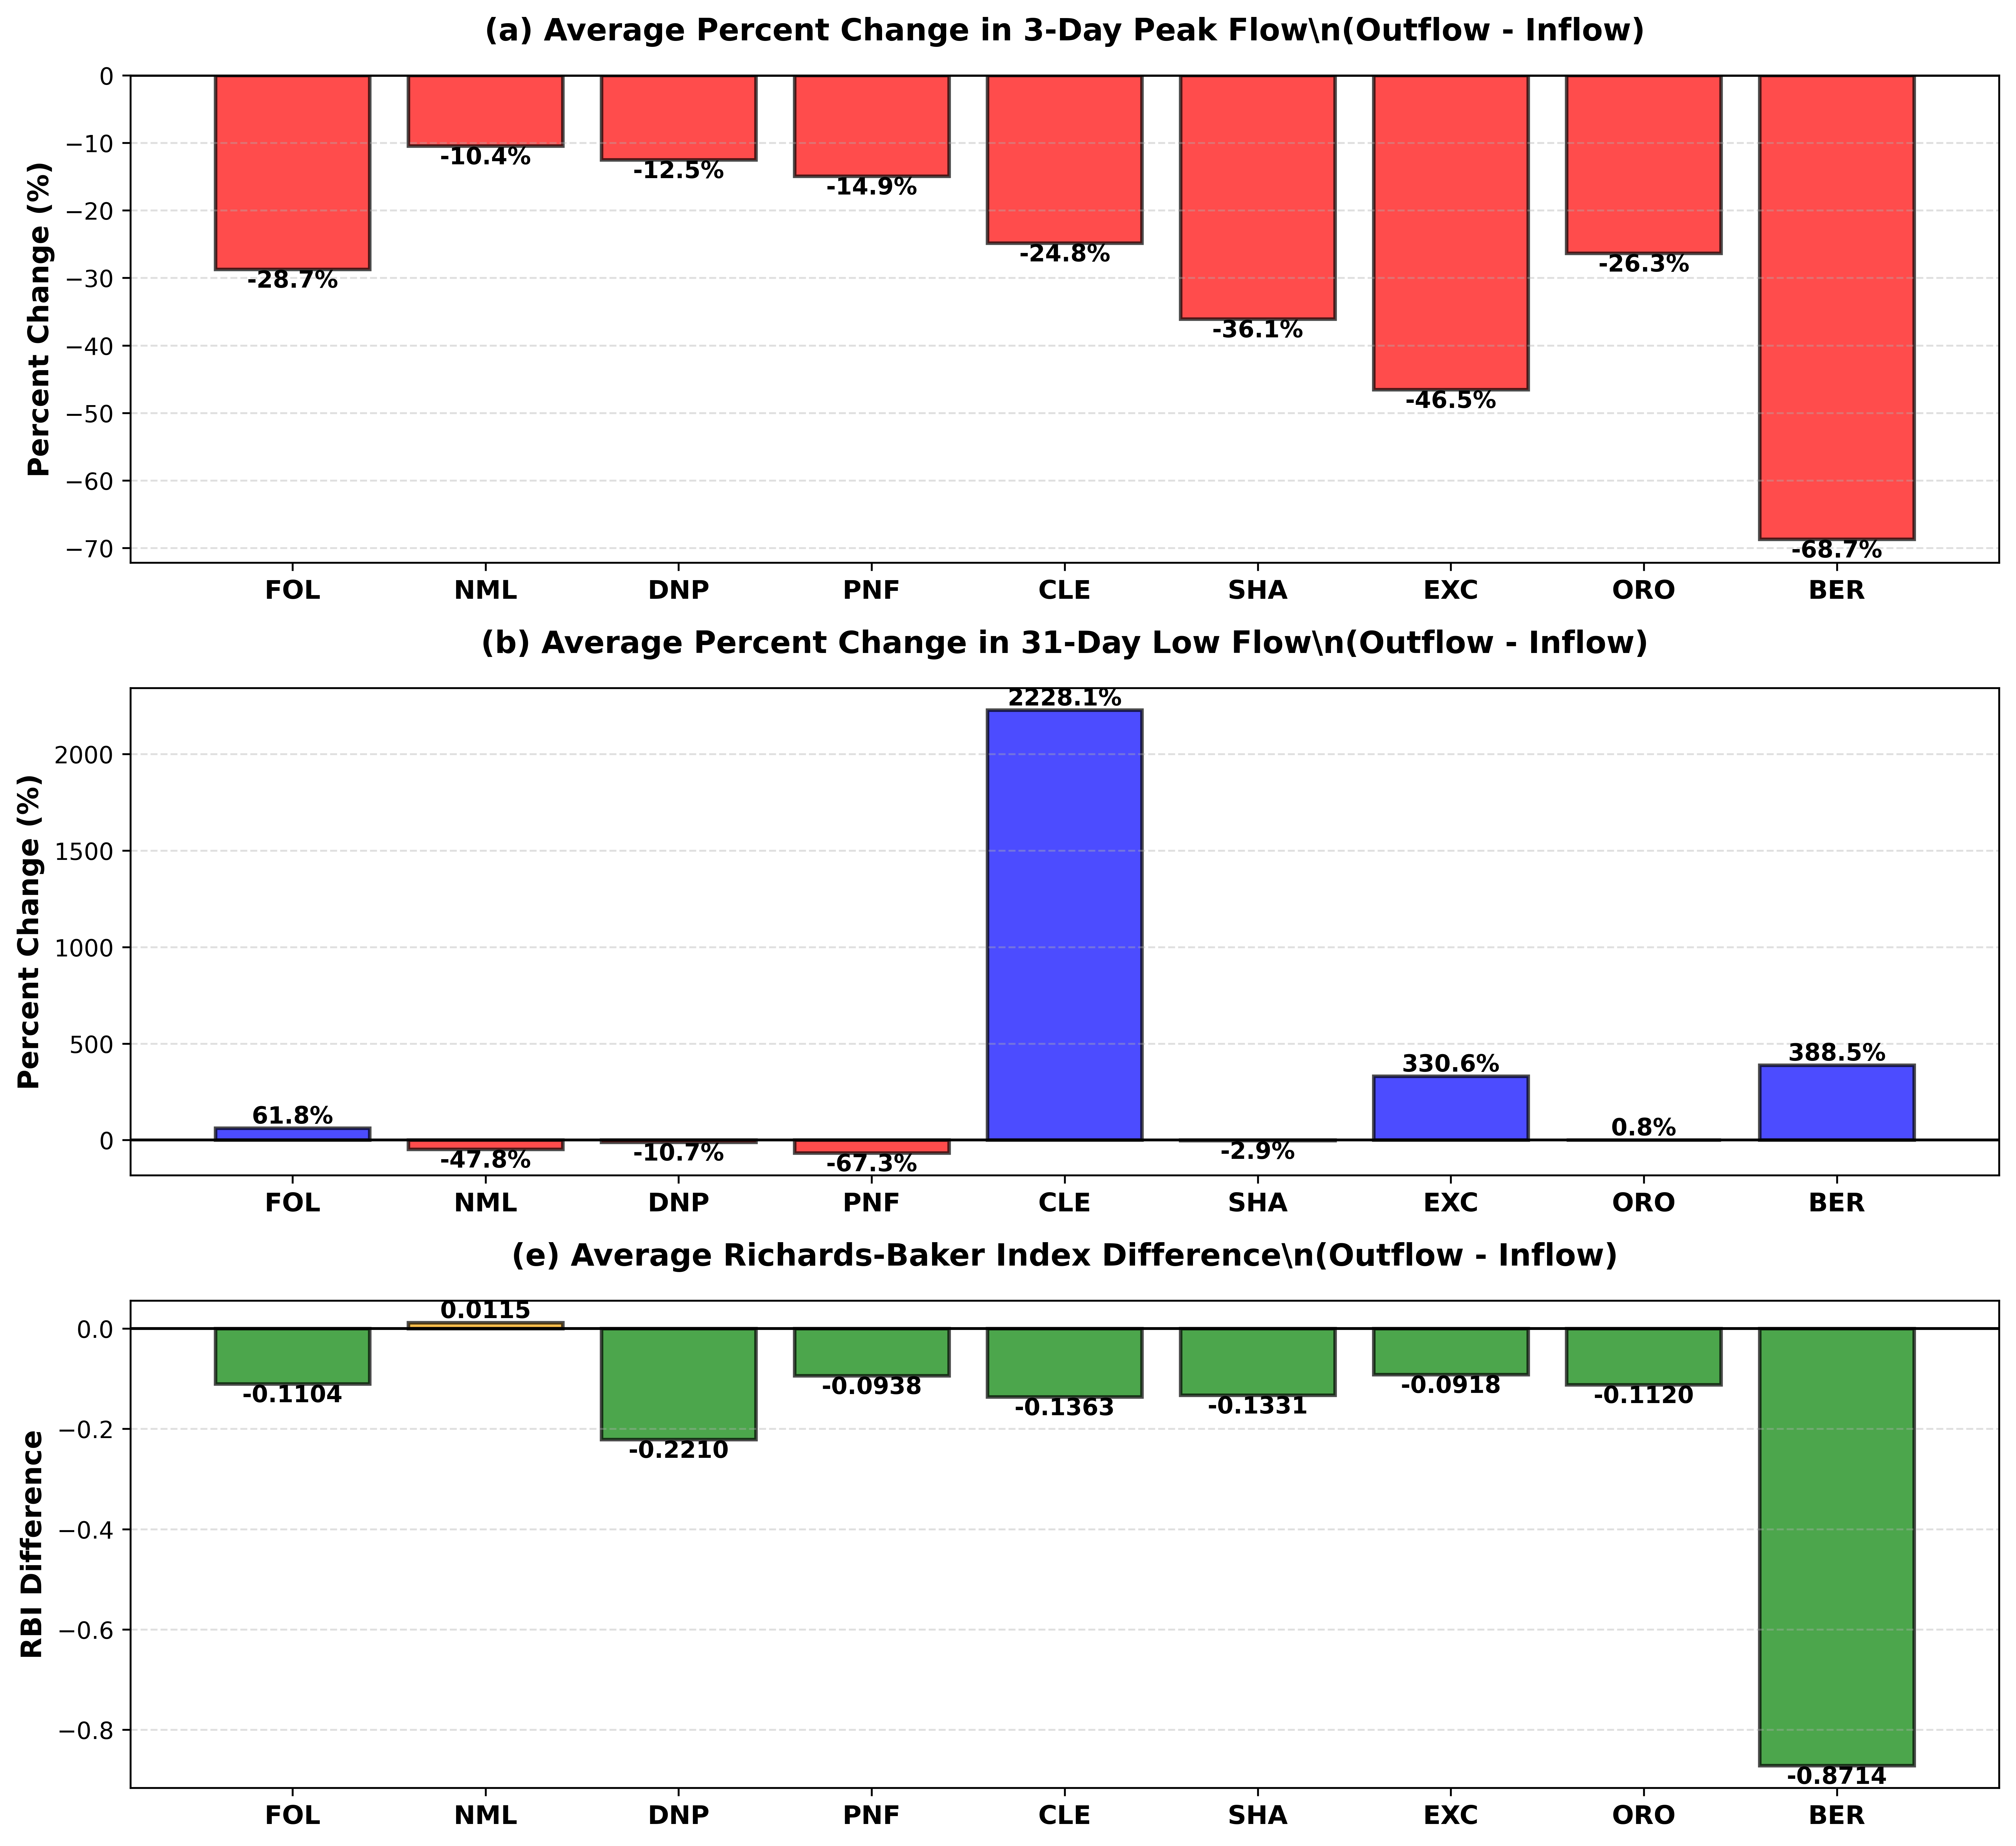

In [38]:
#ANALYSIS FUNCTIONS
def analyze_reservoir(filepath, reservoir_name):
    """
    Analyze a single reservoir
    """
    print(f"\n{'='*60}")
    print(f"Analyzing: {reservoir_name}")
    print(f"{'='*60}")
    
    # Load and preprocess
    df = load_and_preprocess(filepath)
    
    print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"Total days: {len(df)}")
    print(f"Water years: {sorted(df['water_year'].unique())}")
    
    # Calculate all indicators
    results = {
        'a_3day_peak_pct': calculate_indicator_a(df),
        'b_31day_low_pct': calculate_indicator_b(df),
        'c_3day_timing': calculate_indicator_c(df),
        'd_31day_timing': calculate_indicator_d(df),
        'e_flashiness': calculate_indicator_e(df)
    }
    
    # Print summary statistics
    print(f"\nResults (averaged across {len(results['a_3day_peak_pct'])} water years):")
    print(f"  (a) Avg % change 3-day peak:   {results['a_3day_peak_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (b) Avg % change 31-day low:   {results['b_31day_low_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (c) Avg timing diff 3-day:     {results['c_3day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (d) Avg timing diff 31-day:    {results['d_31day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (e) Avg RBI difference:        {results['e_flashiness']['rbi_diff'].mean():>8.4f}")
    
    return results, df

def analyze_multiple_reservoirs(data_dir):
    """
    Analyze all reservoirs in the data directory
    """
    all_results = {}
    
    data_path = Path(data_dir)
    
    # Find all CSV files
    csv_files = list(data_path.glob('*-daily-flows.csv'))
    
    if not csv_files:
        print(f"ERROR: No '*-daily-flows.csv' files found in {data_dir}")
        return None
    
    print(f"\nFound {len(csv_files)} reservoir(s):")
    for f in csv_files:
        print(f"  - {f.name}")
    
    # Analyze each reservoir
    for csv_file in csv_files:
        # Extract reservoir name (e.g., 'BER' from 'BER-daily-flows.csv')
        res_name = csv_file.stem.replace('-daily-flows', '')
        
        results, df = analyze_reservoir(csv_file, res_name)
        all_results[res_name] = results
    
    return all_results

def create_summary_table(all_results):
    """
    Create summary dataframe with average values for each reservoir
    """
    summary = []
    
    for res_name, results in all_results.items():
        summary.append({
            'Reservoir': res_name,
            'Avg_3day_peak_%_change': results['a_3day_peak_pct']['pct_change'].mean(),
            'Avg_31day_low_%_change': results['b_31day_low_pct']['pct_change'].mean(),
            'Avg_3day_timing_shift_days': results['c_3day_timing']['timing_diff'].mean(),
            'Avg_31day_timing_shift_days': results['d_31day_timing']['timing_diff'].mean(),
            'Avg_RBI_difference': results['e_flashiness']['rbi_diff'].mean(),
            'Num_water_years': len(results['a_3day_peak_pct'])
        })
    
    return pd.DataFrame(summary)

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_indicators(summary_df, output_dir='/home/claude/'):
    """
    Create bar plots for indicators (a), (b), and (e)
    One plot per indicator, showing all reservoirs
    """
    reservoirs = summary_df['Reservoir'].tolist()
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 11))
    
    # ========================================================================
    # Plot (a): 3-day peak flow percent change
    # ========================================================================
    ax = axes[0]
    values_a = summary_df['Avg_3day_peak_%_change'].values
    colors_a = ['red' if v < 0 else 'blue' for v in values_a]
    
    bars_a = ax.bar(range(len(reservoirs)), values_a, color=colors_a, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(a) Average Percent Change in 3-Day Peak Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars_a, values_a)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # ========================================================================
    # Plot (b): 31-day low flow percent change
    # ========================================================================
    ax = axes[1]
    values_b = summary_df['Avg_31day_low_%_change'].values
    colors_b = ['blue' if v > 0 else 'red' for v in values_b]
    
    bars_b = ax.bar(range(len(reservoirs)), values_b, color=colors_b, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(b) Average Percent Change in 31-Day Low Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_b, values_b)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # ========================================================================
    # Plot (e): RBI difference
    # ========================================================================
    ax = axes[2]
    values_e = summary_df['Avg_RBI_difference'].values
    colors_e = ['green' if v < 0 else 'orange' for v in values_e]
    
    bars_e = ax.bar(range(len(reservoirs)), values_e, color=colors_e, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('RBI Difference', fontsize=12, fontweight='bold')
    ax.set_title('(e) Average Richards-Baker Index Difference\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_e, values_e)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    output_path = Path(output_dir) / 'reservoir_indicators_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved: {output_path}")
    
    return fig

# ============================================================================
# INTERPRETATION
# ============================================================================

def generate_interpretation(summary_df):
    """
    Generate interpretation of findings
    """
    lines = []
    
    lines.append("=" * 80)
    lines.append("INTERPRETATION OF FINDINGS")
    lines.append("=" * 80)
    lines.append("")
    
    # Overall patterns
    lines.append("1. PEAK FLOW ALTERATION (Indicator a):")
    lines.append("-" * 60)
    
    avg_peak_change = summary_df['Avg_3day_peak_%_change'].mean()
    
    if avg_peak_change < 0:
        lines.append(f"   • On average, reservoirs REDUCE peak flows by {abs(avg_peak_change):.1f}%")
        lines.append("   • This demonstrates flood control function")
        lines.append("   • Peaks are attenuated by storing water during high flow events")
    else:
        lines.append(f"   • On average, peak flows INCREASE by {avg_peak_change:.1f}%")
        lines.append("   • This may indicate coordinated releases or flood routing")
    
    # Individual reservoirs
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_3day_peak_%_change']:.1f}% change")
    
    lines.append("")
    
    # Low flow alteration
    lines.append("2. LOW FLOW ALTERATION (Indicator b):")
    lines.append("-" * 60)
    
    avg_low_change = summary_df['Avg_31day_low_%_change'].mean()
    
    if avg_low_change > 0:
        lines.append(f"   • On average, reservoirs AUGMENT low flows by {avg_low_change:.1f}%")
        lines.append("   • Stored water is released during dry periods")
        lines.append("   • This benefits downstream ecosystems and water supply")
    else:
        lines.append(f"   • On average, low flows DECREASE by {abs(avg_low_change):.1f}%")
        lines.append("   • Water is being retained during low flow periods")
    
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_31day_low_%_change']:.1f}% change")
    
    lines.append("")
    
    # Flashiness (RBI)
    lines.append("3. FLASHINESS - Richards-Baker Index (Indicator e):")
    lines.append("-" * 60)
    lines.append("")
    lines.append("   HOW FLASHINESS IS CALCULATED:")
    lines.append("   • Formula: RBI = Σ|Qᵢ - Qᵢ₋₁| / ΣQᵢ")
    lines.append("   • Numerator: Sum of absolute day-to-day flow changes")
    lines.append("   • Denominator: Total flow volume (normalization)")
    lines.append("   • Steps:")
    lines.append("     1. For each day, calculate: change = |today's flow - yesterday's flow|")
    lines.append("     2. Sum all daily changes")
    lines.append("     3. Divide by sum of all daily flows")
    lines.append("")
    lines.append("   WHAT THIS INDEX CAPTURES:")
    lines.append("   • Frequency of flow changes (how often flow varies)")
    lines.append("   • Magnitude of flow changes (how much flow varies)")
    lines.append("   • Flow stability:")
    lines.append("     - Low RBI (0.05-0.10) = Stable, regulated flows")
    lines.append("     - High RBI (0.30-0.50) = Flashy, rapidly changing flows")
    lines.append("   • Dimensionless → allows comparison between different sized streams")
    lines.append("")
    lines.append("   RESULTS:")
    
    avg_rbi_change = summary_df['Avg_RBI_difference'].mean()
    
    if avg_rbi_change < 0:
        lines.append(f"   • Average RBI reduction: {abs(avg_rbi_change):.4f}")
        lines.append("   • Reservoirs REDUCE flashiness (stabilize flows)")
        lines.append("   • This is typical: storage dampens natural variability")
        lines.append("   • Benefits: More predictable habitat conditions")
    else:
        lines.append(f"   • Average RBI increase: {avg_rbi_change:.4f}")
        lines.append("   • Reservoirs INCREASE flashiness")
        lines.append("   • May indicate hydropeaking (rapid changes for power generation)")
        lines.append("   • Concerns: Stressful for aquatic organisms")
    
    lines.append("")
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_RBI_difference']:.4f} change")
    
    lines.append("")
    lines.append("")
    
    # Capacity relationship
    lines.append("4. RELATIONSHIP BETWEEN RESERVOIR CAPACITY AND ALTERATION:")
    lines.append("-" * 60)
    lines.append("")
    lines.append("   GENERAL PRINCIPLES:")
    lines.append("   • Larger reservoirs have greater storage capacity")
    lines.append("   • Greater capacity = greater ability to modify flows")
    lines.append("   • Expected patterns:")
    lines.append("     - Large reservoirs: Strong peak reduction, high low flow augmentation")
    lines.append("     - Small reservoirs: Minimal alterations, flows similar to natural")
    lines.append("")
    
    # If we have capacity data, we could add correlation analysis here
    lines.append("   OBSERVATIONS FROM CURRENT DATA:")
    
    # Sort by peak reduction to identify patterns
    sorted_by_peak = summary_df.sort_values('Avg_3day_peak_%_change')
    
    lines.append(f"   • Most peak reduction: {sorted_by_peak.iloc[0]['Reservoir']} " +
                f"({sorted_by_peak.iloc[0]['Avg_3day_peak_%_change']:.1f}%)")
    lines.append(f"   • Least peak reduction: {sorted_by_peak.iloc[-1]['Reservoir']} " +
                f"({sorted_by_peak.iloc[-1]['Avg_3day_peak_%_change']:.1f}%)")
    
    lines.append("")
    lines.append("   To properly assess capacity-alteration relationships, we would need:")
    lines.append("   • Reservoir storage capacity (acre-feet or m³)")
    lines.append("   • Storage capacity to mean annual flow ratio")
    lines.append("   • Then perform correlation analysis")
    
    lines.append("")
    lines.append("")
    
    # Ecological implications
    lines.append("5. ECOLOGICAL AND MANAGEMENT IMPLICATIONS:")
    lines.append("-" * 60)
    lines.append("   • Flow regime is a 'master variable' for river ecosystems")
    lines.append("   • Peak flow reductions:")
    lines.append("     - Reduce flooding risk (positive for humans)")
    lines.append("     - May prevent channel-forming flows (negative for habitat)")
    lines.append("     - Can reduce floodplain connectivity")
    lines.append("   • Low flow augmentation:")
    lines.append("     - Maintains minimum flows for aquatic life")
    lines.append("     - Prevents thermal stress and low dissolved oxygen")
    lines.append("     - Supports fish passage and migration")
    lines.append("   • Timing shifts:")
    lines.append("     - Affect spawning cues and migration timing")
    lines.append("     - May desynchronize ecological relationships")
    lines.append("   • Flashiness changes:")
    lines.append("     - Reduced flashiness stabilizes benthic communities")
    lines.append("     - But may reduce natural flow variability that species need")
    
    lines.append("")
    lines.append("=" * 80)
    
    return "\\n".join(lines)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function
    """
    print("\\n" + "=" * 80)
    print("RESERVOIR HYDROLOGICAL INDICATORS ANALYSIS")
    print("Assignment 2 - CEE690-ESAA")
    print("=" * 80)
    
    # Set data directory
    data_dir = "/Users/weilynnw/Desktop/CEE690-ESAA-main/assignment_2_data"
    
    # Analyze all reservoirs
    all_results = analyze_multiple_reservoirs(data_dir)
    
    if all_results is None:
        print("\\nERROR: No data found. Please check file locations.")
        return
    
    # Create summary table
    summary_df = create_summary_table(all_results)
    
    print("\\n" + "=" * 80)
    print("SUMMARY TABLE")
    print("=" * 80)
    print(summary_df.to_string(index=False))
    
    # Save summary
    summary_path = '/Users/weilynnw/Desktop/CEE690-ESAA-main/a2output/reservoir_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"\\n✓ Summary saved: {summary_path}")
    
    # Create plots
    print("\\n" + "=" * 80)
    print("GENERATING PLOTS")
    print("=" * 80)
    plot_indicators(summary_df, output_dir='/Users/weilynnw/Desktop/CEE690-ESAA-main/a2output')
    
    # Generate interpretation
    interpretation = generate_interpretation(summary_df)
    
    print("\\n" + interpretation)
    
    # Save interpretation
    interp_path = '/Users/weilynnw/Desktop/CEE690-ESAA-main/a2output/interpretation.txt'
    with open(interp_path, 'w') as f:
        f.write(interpretation)
    print(f"\\n✓ Interpretation saved: {interp_path}")
    
    print("\\n" + "=" * 80)
    print("✓ ANALYSIS COMPLETE!")
    print("=" * 80)
    print("\\nGenerated files:")
    print("  1. reservoir_summary.csv - Summary statistics")
    print("  2. reservoir_indicators_analysis.png - Bar plots")
    print("  3. interpretation.txt - Written interpretation")
    print("=" * 80)
    
    return all_results, summary_df
# RUN ANALYSIS

if __name__ == "__main__":
    results, summary = main()


# Q2:

# Q3:

# Q4:

# Q5: